<a href="https://colab.research.google.com/github/pranav168/Customer-Segmentation/blob/main/Online_Retail_Customer_Segmentation_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Extraction/identification of major topics & themes discussed in news articles. </u></b>

## <b> Problem Description </b>

### In this project, your task is to identify major customer segments on a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## <b> Data Description </b>

### <b>Attribute Information: </b>

* ### InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
* ### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
* ### Description: Product (item) name. Nominal.
* ### Quantity: The quantities of each product (item) per transaction. Numeric.
* ### InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
* ### UnitPrice: Unit price. Numeric, Product price per unit in sterling.
* ### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
* ### Country: Country name. Nominal, the name of the country where each customer resides.

In [1]:
from google.colab import drive                                                  #mounting drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
import pandas as pd                                                             #loading all the Required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.ensemble import IsolationForest  
import warnings                                                                 # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mpl_toolkits import mplot3d
from pylab import rcParams                                                      
rcParams['figure.figsize'] = 30, 10
import scipy.cluster.hierarchy as sch

In [3]:
df= pd.read_excel('/content/drive/MyDrive/Copy of Online Retail.xlsx')          #Loading the Dataset

In [4]:
df.info()                                                                       #Data contains a lot of Nan

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isna().sum()                                                                 #135080 nulls in Customer id and 1454 nulls in Description

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
column_list=['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                               
  count_dataset[i]= pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(df[i].value_counts().index),df[i].value_counts().sum(),df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally=list(zip(column_list,distinct_features))                                                          #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['CustomerID','Description']:                                                                       #colur red shows the  Variable with missing values
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,InvoiceNo,InvoiceNo_count,StockCode,StockCode_count,Description,Description_count,Quantity,Quantity_count,InvoiceDate,InvoiceDate_count,UnitPrice,UnitPrice_count,CustomerID,CustomerID_count,Country,Country_count
0,573585,1114,85123A,2313,WHITE HANGING HEART T-LIGHT HOLDER,2369,1,148227,2011-10-31 14:41:00,1114,1.250000,50496,17841.000000,7983,United Kingdom,495478
1,581219,749,22423,2203,REGENCY CAKESTAND 3 TIER,2200,2,81829,2011-12-08 09:28:00,749,1.650000,38181,14911.000000,5903,Germany,9495
2,581492,731,85099B,2159,JUMBO BAG RED RETROSPOT,2159,12,61063,2011-12-09 10:03:00,731,0.850000,28497,14096.000000,5128,France,8557
3,580729,721,47566,1727,PARTY BUNTING,1727,6,40868,2011-12-05 17:24:00,721,2.950000,27768,12748.000000,4642,EIRE,8196
4,558475,705,20725,1639,LUNCH BAG RED RETROSPOT,1638,4,38484,2011-06-29 15:58:00,705,0.420000,24533,14606.000000,2782,Spain,2533
5,579777,687,84879,1502,ASSORTED COLOUR BIRD ORNAMENT,1501,3,37121,2011-11-30 15:13:00,687,4.950000,19040,15311.000000,2491,Netherlands,2371
6,581217,676,22720,1477,SET OF 3 CAKE TINS PANTRY DESIGN,1473,24,24021,2011-12-08 09:20:00,676,3.750000,18600,14646.000000,2085,Belgium,2069
7,537434,675,22197,1476,PACK OF 72 RETROSPOT CAKE CASES,1385,10,22288,2010-12-06 16:57:00,675,2.100000,17697,13089.000000,1857,Switzerland,2002
8,580730,662,21212,1385,LUNCH BAG BLACK SKULL.,1350,8,13129,2011-12-05 17:28:00,662,2.460000,17091,13263.000000,1677,Portugal,1519
9,538071,652,20727,1350,NATURAL SLATE HEART CHALKBOARD,1280,5,11757,2010-12-09 14:09:00,652,2.080000,17005,14298.000000,1640,Australia,1259


In [8]:
final_tally                                                                     # Gives (No. of unique elements in Variable, Total of all Variable, Total of Top 10 Variable )                                                          

[('InvoiceNo', (25900, 541909, 7372)),
 ('StockCode', (4070, 541909, 17231)),
 ('Description', (4223, 540455, 17082)),
 ('Quantity', (722, 541909, 478787)),
 ('InvoiceDate', (23260, 541909, 7372)),
 ('UnitPrice', (1630, 541909, 258908)),
 ('CustomerID', (4372, 406829, 36188)),
 ('Country', (38, 541909, 533479))]

here important thing to note is that :


1.   Only 25900 unique Invoice
2.   Only 4070 unique StokeCode(which means number of products =4070)
3.   There are only 4372 Unique Customers (thus we should look a way to group data as per customers, thus we will have to treat the customers with Nan values as similar.
4.  only 38 Country of which 10 country represents almost entire data, and UK alone explain 90% Data thus we will group country 'UK' as 1 and 'Others' as 0.
5.  Also well be droping Description Coulmns as we already have Stockcode for product mapping also their are few Nan in Description Coulmns.



In [9]:
df['Order Status']=df['InvoiceNo'].apply(lambda x: np.where(str(x)[0]=='C',0,1))                 #As there are some Canceled Data in the Transaction well be marking them as '0'.
print(df['Order Status'].value_counts())                                                         #Counting the Number of Canceled Orders.
try:
  df.drop('Description',axis=1,inplace=True)
  df.dropna(inplace=True)
except:
  pass
df['Country']=df['Country'].apply(lambda x: np.where(x=='United Kingdom','1','0'))
df.head()

1    532621
0      9288
Name: Order Status, dtype: int64


,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Order Status
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,1,1
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,1,1
2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,1,1
3,536365,84029G,6,2010-12-01 08:26:00,3.39,17850.0,1,1
4,536365,84029E,6,2010-12-01 08:26:00,3.39,17850.0,1,1


In [10]:
df.describe()                                                                   #their is Negative Values in Quantity lets explore this column

,Quantity,UnitPrice,CustomerID,Order Status
count,406829.000000,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570,0.978111
std,248.693370,69.315162,1713.600303,0.146321
min,-80995.000000,0.000000,12346.000000,0.000000
25%,2.000000,1.250000,13953.000000,1.000000
50%,5.000000,1.950000,15152.000000,1.000000
75%,12.000000,3.750000,16791.000000,1.000000
max,80995.000000,38970.000000,18287.000000,1.000000


In [11]:
df[df.Quantity<=0].head()                                                        #these are all Canceled Transanctions thus products are returned we can now remove InvoiceNo as we have saved that feature in order status
try:                                                    
  df.drop('InvoiceNo',axis=1,inplace=True)
except:
  pass

In [12]:
df['Temp_col']=df['StockCode'].apply(lambda x: np.where(len(str(x))==5,1,0))    # As stock code be a number of 5 digit we should look at the anomalies over here
print(df.Temp_col.value_counts())
df[df['Temp_col']==0].head()                                                    # Nothing conclusive found thus i will retain these values for futher and Dropping the temp column
try:
  df.drop('Temp_col',axis=1,inplace=True)
except:
  pass

1    371020
0     35809
Name: Temp_col, dtype: int64


In [13]:
print(type(df['InvoiceDate'][0]))                                               #Time stamp format
max_date=df['InvoiceDate'].max()
print(max_date)                                                                 #Lets take is date as a refrence for the Last Transaction, thus we will now compute the Last date of each transaction 
print(df['InvoiceDate'].min())
df['Days Before Last Trans']=df['InvoiceDate'].apply(lambda x: (max_date-x).days )

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
2011-12-09 12:50:00
2010-12-01 08:26:00


In [14]:
try:
  df.drop('InvoiceDate',axis=1,inplace=True)                                    # Dropping Invoice as it is of no use now
except:
  pass
df.head()

,StockCode,Quantity,UnitPrice,CustomerID,Country,Order Status,Days Before Last Trans
0,85123A,6,2.55,17850.0,1,1,373
1,71053,6,3.39,17850.0,1,1,373
2,84406B,8,2.75,17850.0,1,1,373
3,84029G,6,3.39,17850.0,1,1,373
4,84029E,6,3.39,17850.0,1,1,373


In [15]:
df['Amount']=df['Quantity']*df['UnitPrice']                                     #Multiplying Qnt and Price per unit to get Amount, and then Droping UnitPrice Column, Using Quantity i will make another Feature later
try:
  df.drop(['UnitPrice'],axis=1,inplace=True)
except:
  pass
df.head()

,StockCode,Quantity,CustomerID,Country,Order Status,Days Before Last Trans,Amount
0,85123A,6,17850.0,1,1,373,15.30
1,71053,6,17850.0,1,1,373,20.34
2,84406B,8,17850.0,1,1,373,22.00
3,84029G,6,17850.0,1,1,373,20.34
4,84029E,6,17850.0,1,1,373,20.34


In [16]:
one_hot_entity=['Order_Status']    
column_one_hot=['Order Status']                                                 #One hot encoding of Order Status so as to get the gist of number of successful, canceled orders
count=0
for i in column_one_hot:
  temp_df=pd.get_dummies(df[i], prefix=one_hot_entity[count])
  count+=1
  df=pd.concat([df, temp_df], axis=1)
try:
  df.drop(['Order Status','StockCode'],axis=1,inplace=True)                     #Dropping Order Status and StockCode as they are of no use now
except:
  pass
df.head()

,Quantity,CustomerID,Country,Days Before Last Trans,Amount,Order_Status_0,Order_Status_1
0,6,17850.0,1,373,15.30,0,1
1,6,17850.0,1,373,20.34,0,1
2,8,17850.0,1,373,22.00,0,1
3,6,17850.0,1,373,20.34,0,1
4,6,17850.0,1,373,20.34,0,1


In [17]:
df1=df.groupby('CustomerID')['Country'].max()                                   # Our Features are now ready and thus i will be making the Final Dataset
df2=df.groupby('CustomerID')['Order_Status_0'].sum()
df3=df.groupby('CustomerID')['Order_Status_1'].sum()
df4=df.groupby('CustomerID')['Days Before Last Trans'].min()
df5=df.groupby('CustomerID')['Amount'].mean()
df6=df.groupby('CustomerID')['Amount'].sum()
df7=df.groupby('CustomerID')['Quantity'].mean()
columns=['Order_Status_0','Order_Status_1','Days Before Last Trans','Avg Amount','Total Amount','Avg_Quantity']
data_frames=[df2,df3,df4,df5,df6,df7]
final_df=pd.DataFrame(df1)
count=0
for i in columns:
  final_df[i]=data_frames[count]
  count+=1

In [18]:
print(final_df.shape)
final_df.head()                                                                 #Our Final Dataset is Completely Ready

(4372, 7)


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity
CustomerID,,,,,,,
12346.0,1,1,1.0,325,0.000000,0.00,0.000000
12347.0,0,0,182.0,1,23.681319,4310.00,13.505495
12348.0,0,0,31.0,74,57.975484,1797.24,75.516129
12349.0,0,0,73.0,18,24.076027,1757.55,8.643836
12350.0,0,0,17.0,309,19.670588,334.40,11.588235


In [19]:
print(np.percentile(final_df.Avg_Quantity, 98))                                 
print(np.percentile(final_df.Avg_Quantity, 99))                                 
print(np.percentile(final_df.Avg_Quantity, 99.5))                               #their is a sudden increase in the value after this
print(np.percentile(final_df.Avg_Quantity, 99.9))
print(np.percentile(final_df.Avg_Quantity, 99.99))
print(np.percentile(final_df.Avg_Quantity, 99.999))                             #Customer ordering more than 386 Quantity on avg is therefor a wholesaler and i will cluster them own my own

100.0
198.8234285714285
386.31999999999243
1639.078500000258
8938.295999999173
12179.829600000667


In [20]:
df_wholesalers=final_df[final_df.Avg_Quantity>=386]
final_df=final_df[final_df.Avg_Quantity<386]
final_df.head()

,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity
CustomerID,,,,,,,
12346.0,1,1,1.0,325,0.000000,0.00,0.000000
12347.0,0,0,182.0,1,23.681319,4310.00,13.505495
12348.0,0,0,31.0,74,57.975484,1797.24,75.516129
12349.0,0,0,73.0,18,24.076027,1757.55,8.643836
12350.0,0,0,17.0,309,19.670588,334.40,11.588235


In [21]:
print(df_wholesalers.shape)
df_wholesalers.head()

(22, 7)


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity
CustomerID,,,,,,,
12798.0,0,0,8.0,9,872.130000,6977.04,657.000000
12875.0,1,0,2.0,142,171.615000,343.23,1009.500000
13027.0,1,0,26.0,113,265.846154,6912.00,664.615385
13135.0,1,0,1.0,196,3096.000000,3096.00,4300.000000
13256.0,1,0,1.0,13,0.000000,0.00,12540.000000


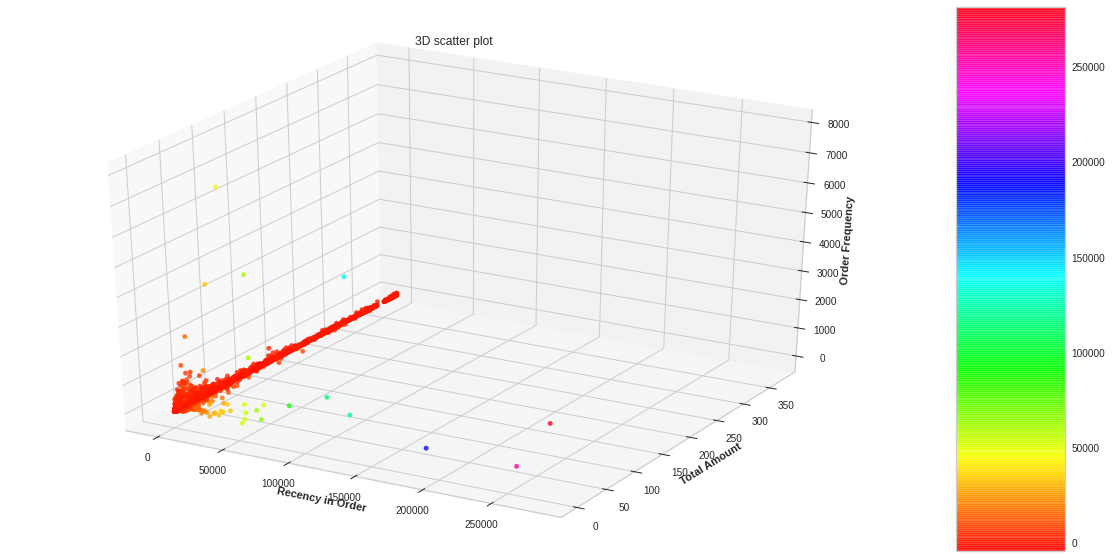

In [24]:
def plot_scatter(final_df):
  fig = plt.figure(figsize = (20, 10))
  ax = plt.axes(projection ="3d")
  # Creating color map
  my_cmap = plt.get_cmap('hsv')
  plot=ax.scatter3D(final_df['Total Amount'],final_df['Days Before Last Trans'],final_df.Order_Status_1,cmap = my_cmap,alpha = 0.8,c =(final_df.Order_Status_1+final_df['Total Amount']+final_df['Days Before Last Trans']) )
  plt.title("3D scatter plot")
  ax.set_zlabel('Order Frequency', fontweight ='bold')
  ax.set_ylabel('Total Amount', fontweight ='bold')
  ax.set_xlabel('Recency in Order', fontweight ='bold')
  fig.colorbar(plot, ax = ax, aspect = 5)
  plt.show()       
                                                                              
plot_scatter(final_df)

(4350, 7)
(4132, 9)


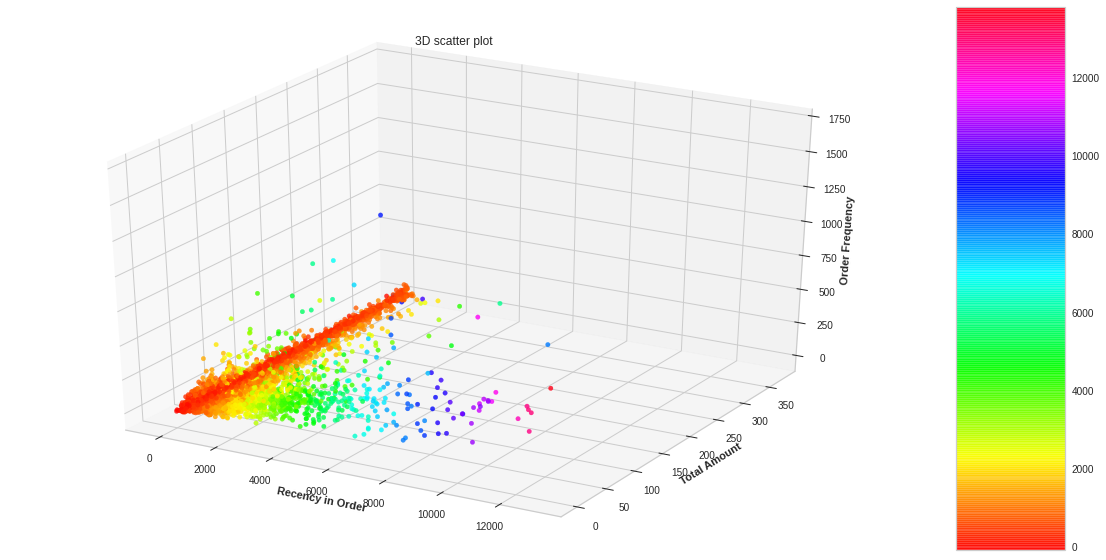

In [25]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(final_df[['Avg Amount','Total Amount','Avg_Quantity']])
clf = IsolationForest(n_estimators=100, contamination=0.05, random_state=0)     #Isolation Forest algorithm for anomaly detection
clf.fit(X)
print(final_df.shape)
final_df['multivariate_anomaly_score'] = clf.decision_function(X)               # predict raw anomaly score
final_df['multivariate_outlier'] = clf.predict(X)                               # prediction of a datapoint category outlier or inlier
final_df=final_df[final_df.multivariate_outlier==1]                             #updating data
print(final_df.shape)                                                           #outliers have been removed
final_df.drop(['multivariate_anomaly_score','multivariate_outlier'],axis=1,inplace=True)
plot_scatter(final_df)

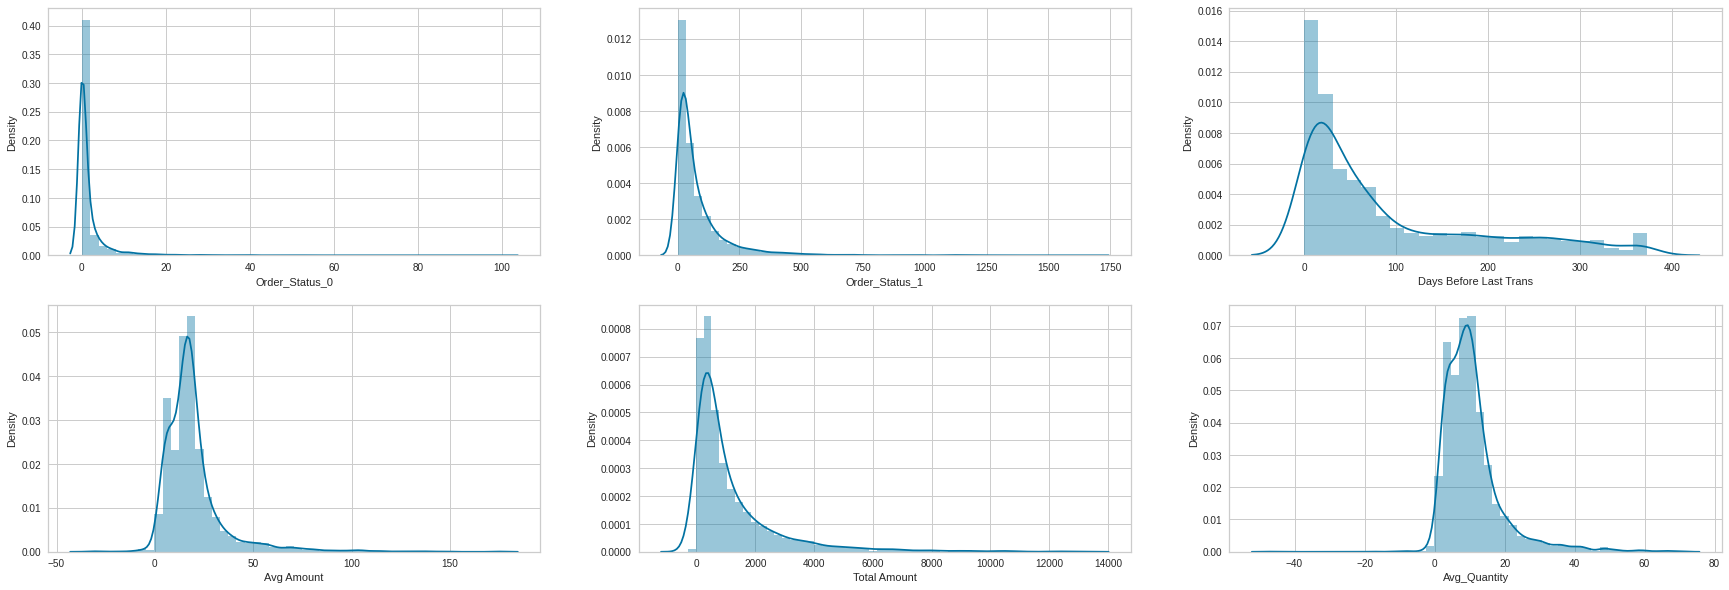

In [26]:
def plot_dist(final_df,fig_size=(30,10),plot_type=0):
  columns=['Order_Status_0','Order_Status_1','Days Before Last Trans','Avg Amount','Total Amount','Avg_Quantity']
  fig,ax=plt.subplots(2,3,figsize=fig_size)
  count=0
  counter=0
  for i in columns:
    if plot_type==0:
      sns.distplot(final_df[i],ax=ax[count,counter])
    else:
      sns.countplot(final_df[i],ax=ax[count,counter])
    counter+=1
    if counter==3:
      counter=0
      count=1
    plt.show
plot_dist(final_df)

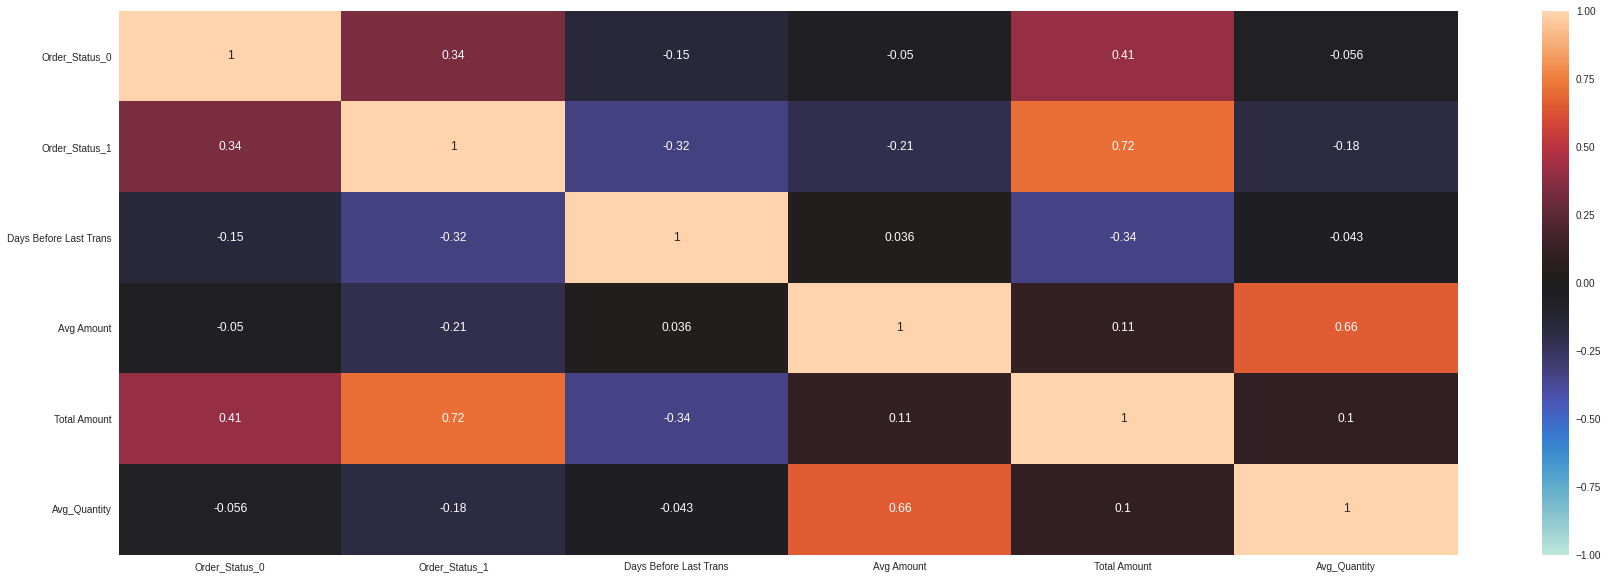

In [27]:
a = final_df.corr()
plt.figure(figsize=(30,10))
sns.heatmap(a,vmin=-1,vmax=1,center=0,annot=True)           #Co-raltion is high between few independent variable, thus their is a possibility that we will have to do pca for feature extraction and dimensionality reduction

For n_clusters = 2, silhouette score is 0.5583074269856291


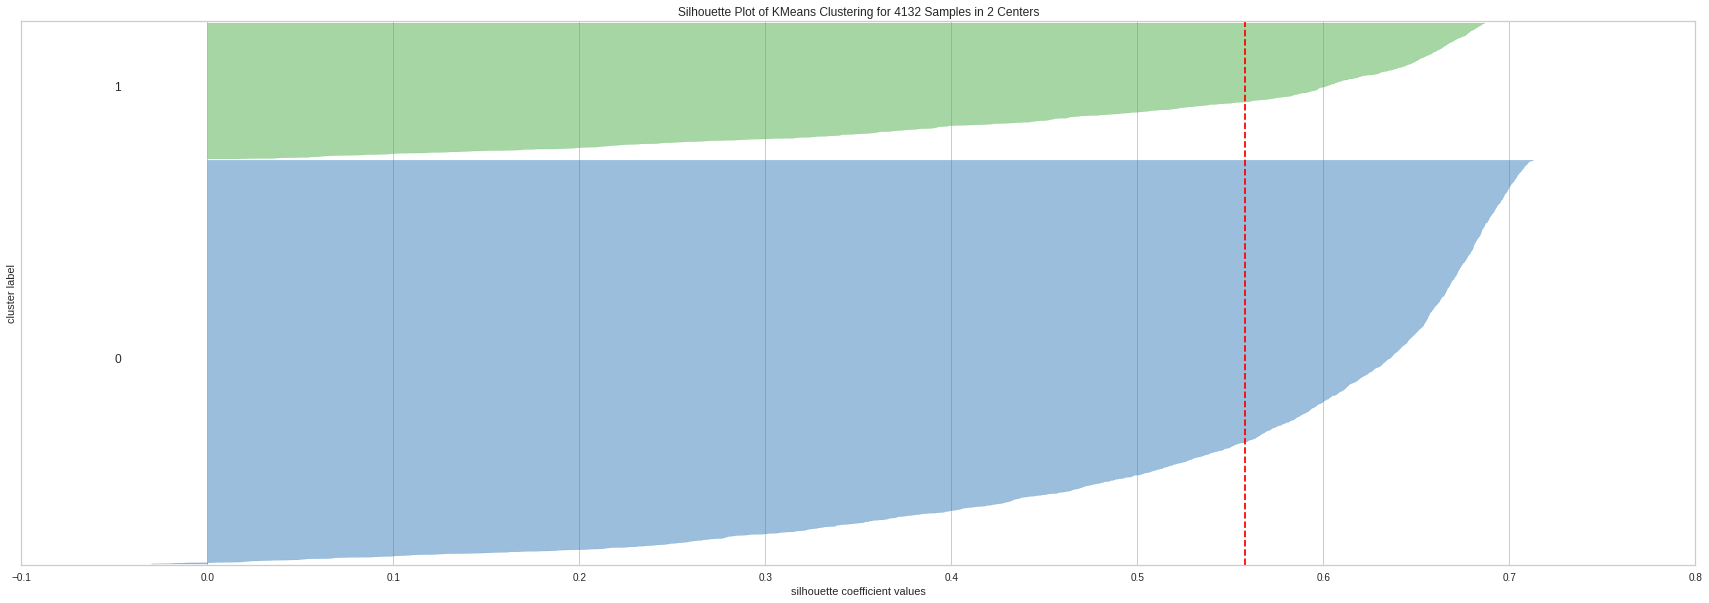

For n_clusters = 3, silhouette score is 0.4763359012829694


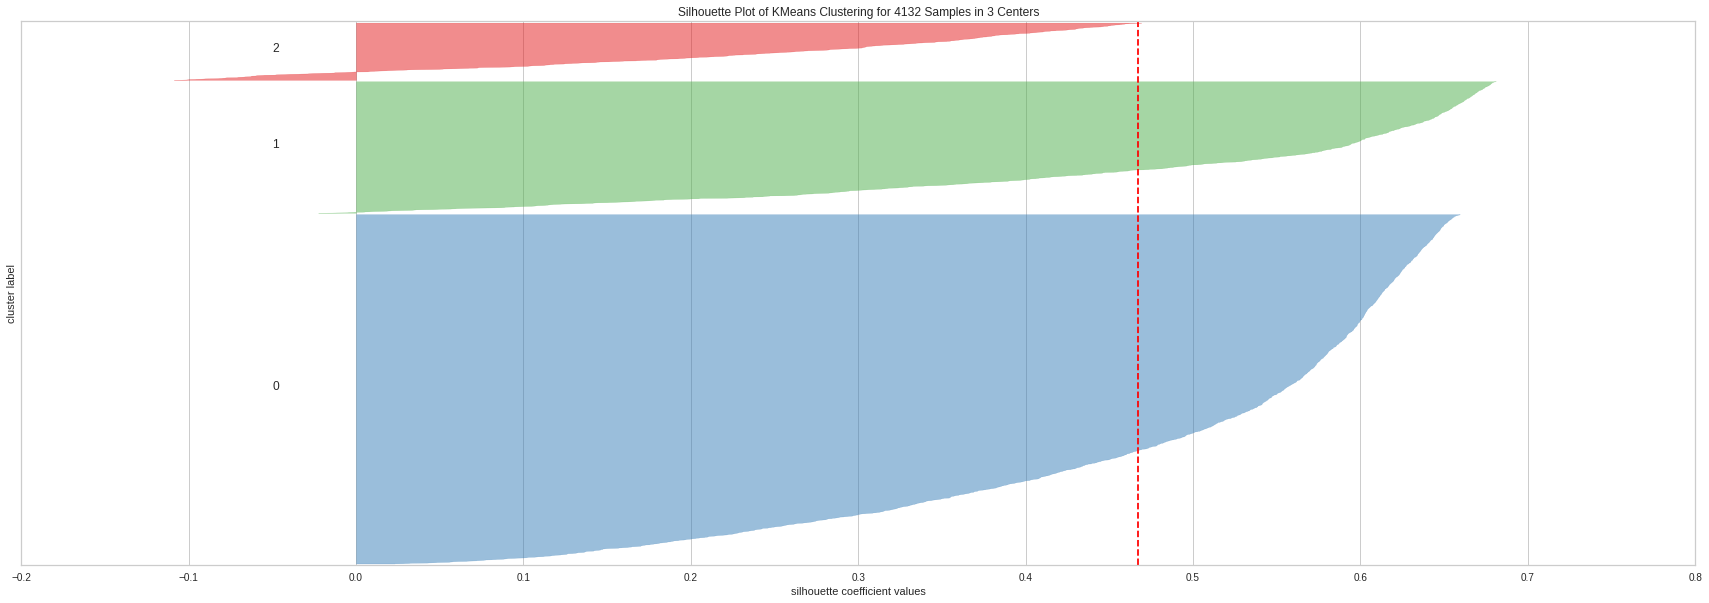

For n_clusters = 4, silhouette score is 0.42087578308160334


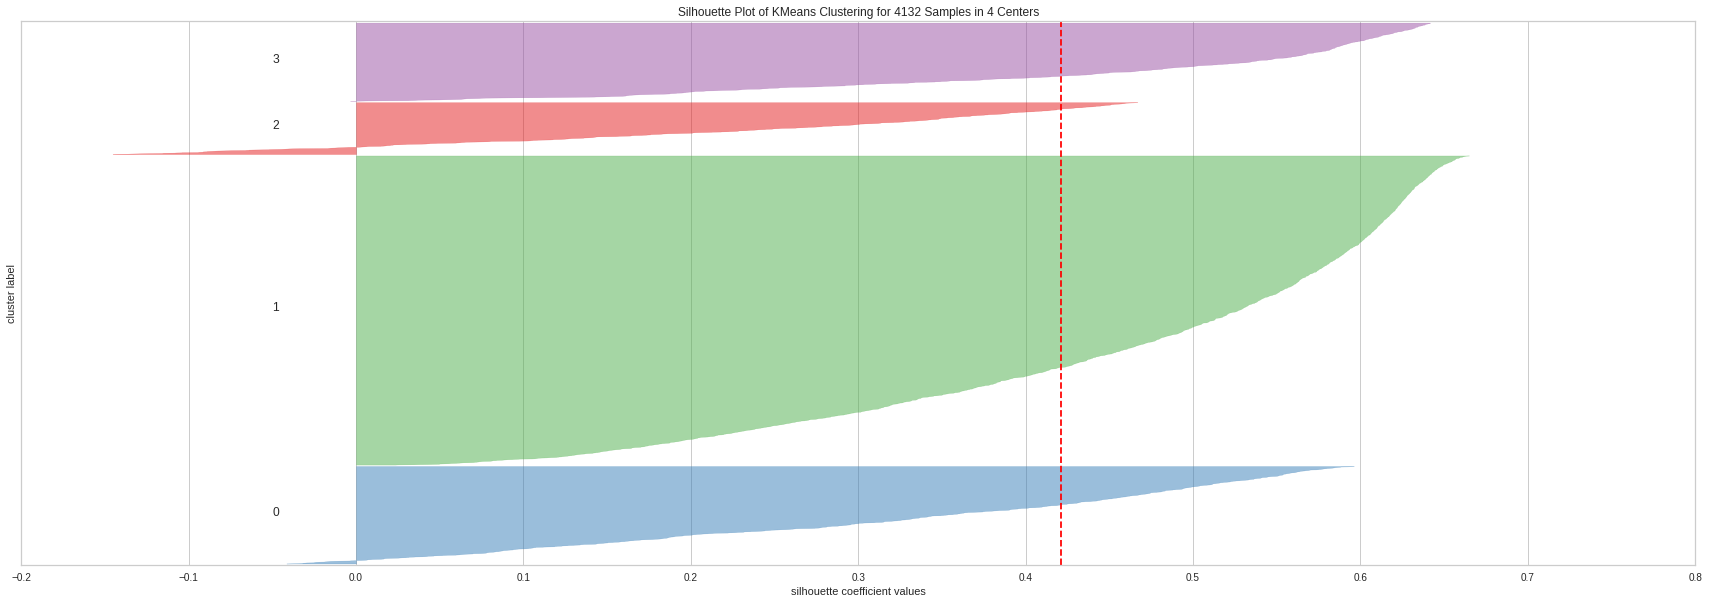

For n_clusters = 5, silhouette score is 0.4277379214659178


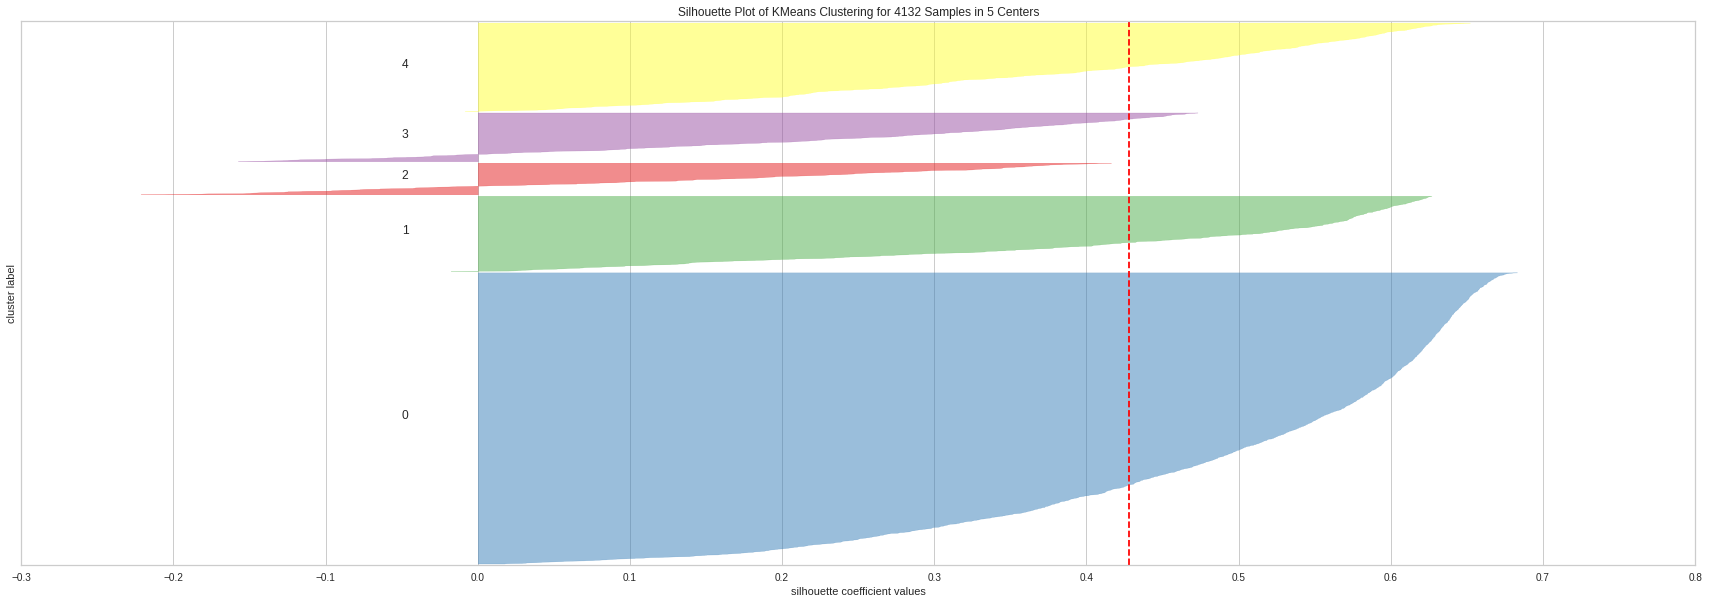

In [28]:
minmax = MinMaxScaler(feature_range=(0, 1))
X = minmax.fit_transform(final_df[['Order_Status_0','Order_Status_1','Days Before Last Trans','Avg Amount','Total Amount','Avg_Quantity']])
def silhouette_score_analysis(n): 
  for n_clusters in range(2,n):
      km = KMeans (n_clusters=n_clusters, max_iter=100,tol=0.01)
      preds = km.fit_predict(X)
      centers = km.cluster_centers_
      score = silhouette_score(X, preds, metric='euclidean')
      print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
      visualizer = SilhouetteVisualizer(km)
      visualizer.fit(X) 
      visualizer.poof() 
silhouette_score_analysis(6)                                                    # More than 5 Clusters would Not seem Logical for Buisness Point of view.                                       

As per Silhouette_score number of Cluster Could be 2 or 3

The innertia for : 2 Clusters is: 192.2443540843187
The innertia for : 3 Clusters is: 147.3060843866467
The innertia for : 4 Clusters is: 116.55536377919431
The innertia for : 5 Clusters is: 100.42517516359318
The innertia for : 6 Clusters is: 89.33647021991288
The innertia for : 7 Clusters is: 79.61208491433041
The innertia for : 8 Clusters is: 73.57988547829648
The innertia for : 9 Clusters is: 67.89062892962464


Text(0.5, 1.0, 'Inertia Plot per k')

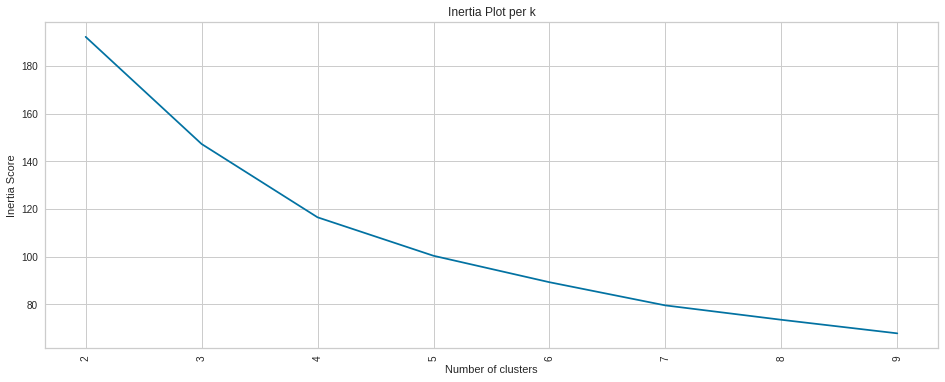

In [29]:
no_of_clusters = range(2,10)
inertia=[]
for f in no_of_clusters:
    kmeans = KMeans(n_clusters=f, random_state=2)
    kmeans = kmeans.fit(X)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", f, "Clusters is:", u)
fig, (ax1) = plt.subplots(1, figsize=(16,6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")                                                 # But As per innertia plot clusters=3.

In [30]:
kmeans = KMeans(n_clusters=3, random_state=2) 
kmeans = kmeans.fit(X)
kmeans.labels_
predictions = kmeans.predict(X)
unique, counts = np.unique(predictions, return_counts=True)
counts = counts.reshape(1,3)
countscldf = pd.DataFrame(counts, columns = ["Cluster 0","Cluster 1","Cluster 2"])
countscldf

,Cluster 0,Cluster 1,Cluster 2
0,2678,1010,444


Explained variance ratio (first two components): [0.71161027 0.14168677 0.09597341]


<Figure size 2160x720 with 0 Axes>

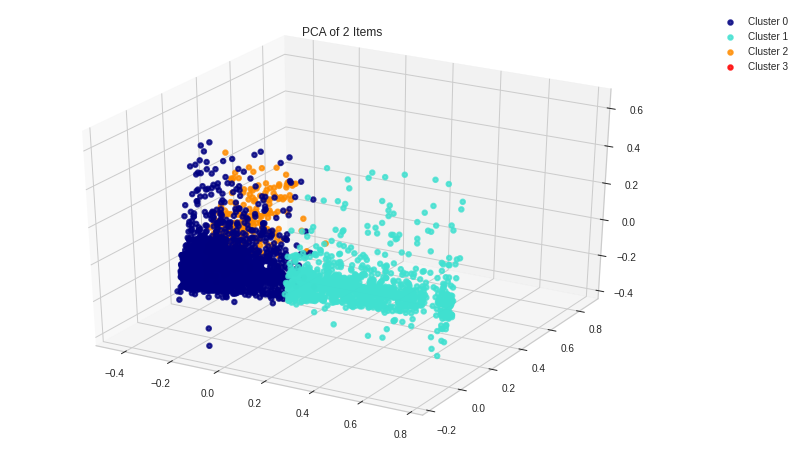

In [33]:
def pca_val(X,predictions): 
  X = X
  y_num = predictions
  pca = PCA(n_components=3, random_state =1 )
  X_r = pca.fit(X).transform(X)
  return X_r,y_num,pca
def plot_3d(X_r,y_num,pca):
  target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3"]
  print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))
  plt.figure()
  plt.figure(figsize=(12,8))
  colors = ['navy', 'turquoise', 'darkorange', 'red']
  lw = 2
  ax = plt.axes(projection ="3d")

  for color, i, target_name in zip(colors, [0, 1, 2, 3,4], target_names):
      ax.scatter3D(X_r[y_num == i, 0], X_r[y_num == i, 1],X_r[y_num == i, 2], color=color, alpha=.8, lw=lw,label=target_name)
      
  plt.legend(loc='best', shadow=False, scatterpoints=1)
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
  plt.title('PCA of 2 Items')
  plt.show()                                                                     #these 3 components represents 95% Variance in data
X_r,y_num,pca=pca_val(X,predictions)
plot_3d(X_r,y_num,pca)

Clusters Looks a bit messed up (might be because there was a little co-relation between the independent variables), we will now be Doing PCA to get better results

For n_clusters = 2, silhouette score is 0.5793215281156991


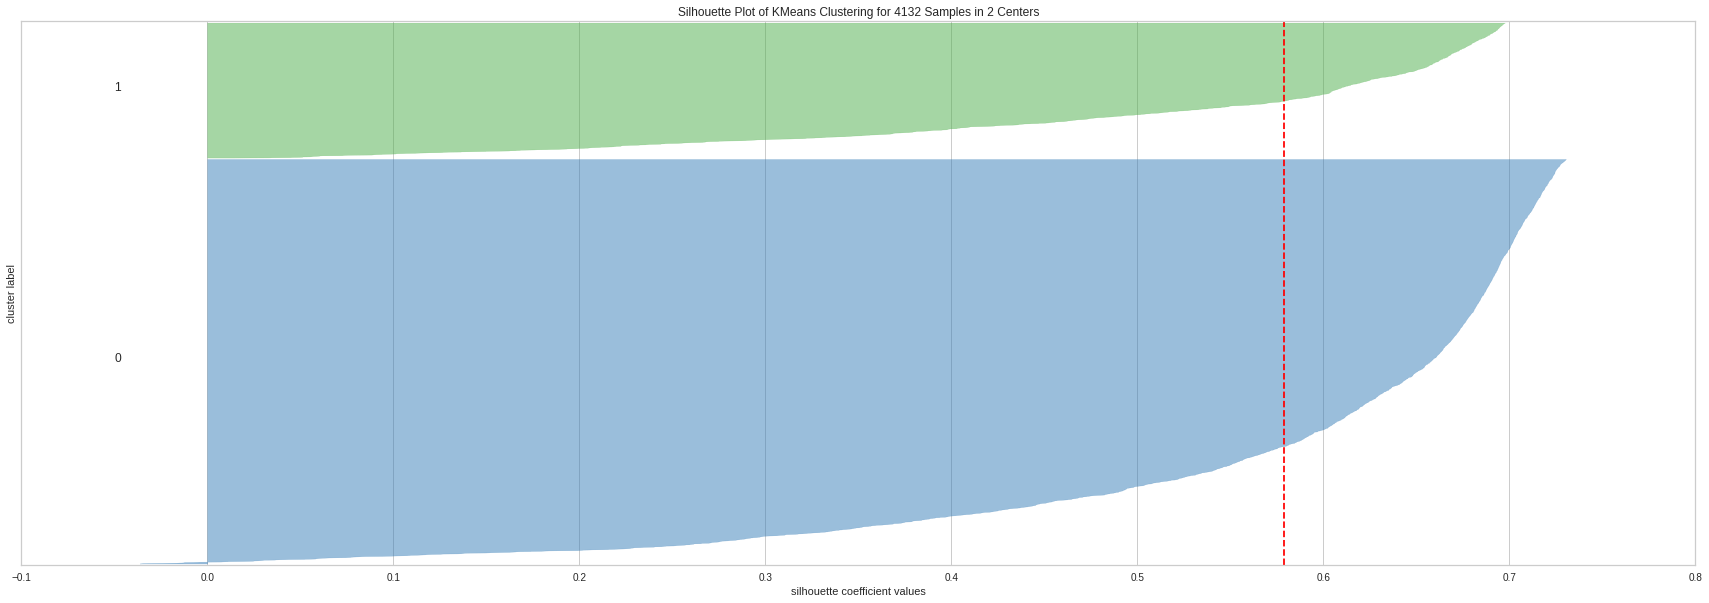

For n_clusters = 3, silhouette score is 0.4918827951914009


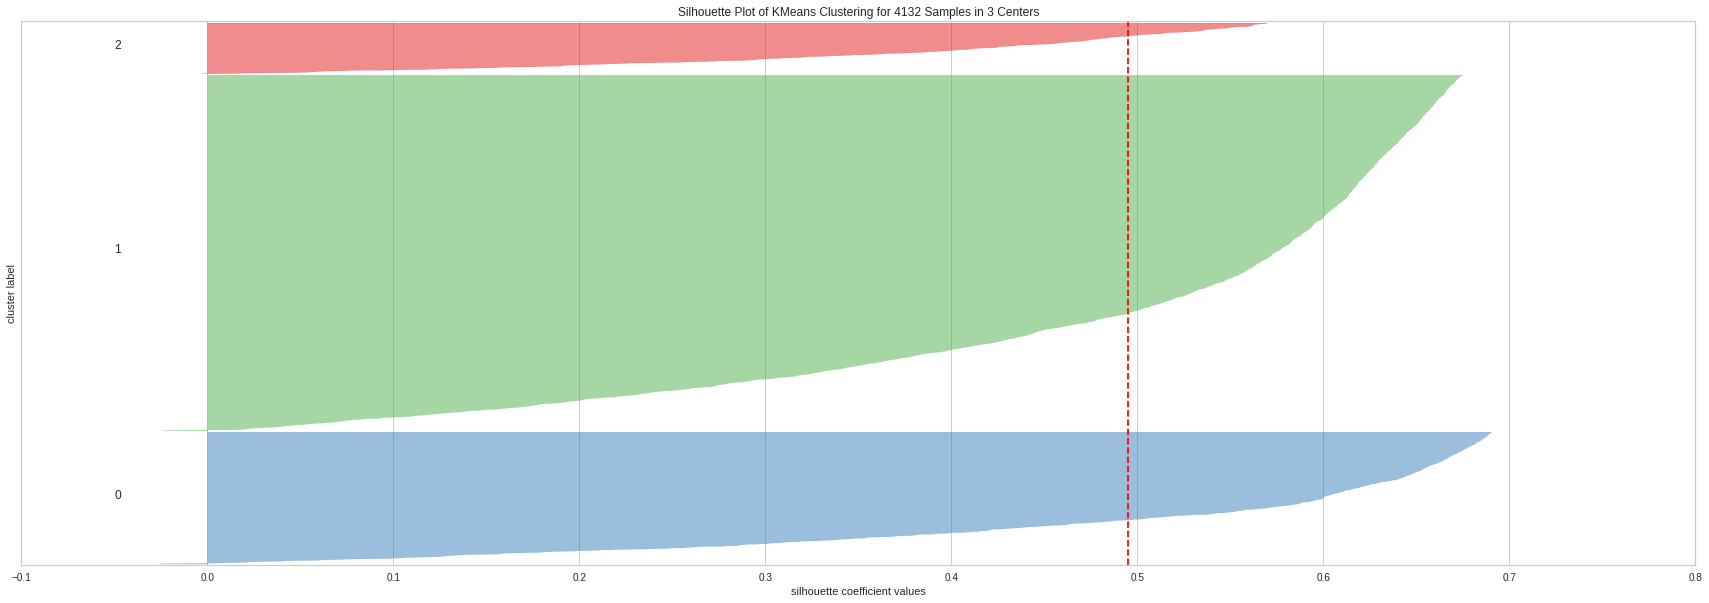

For n_clusters = 4, silhouette score is 0.4505937238040939


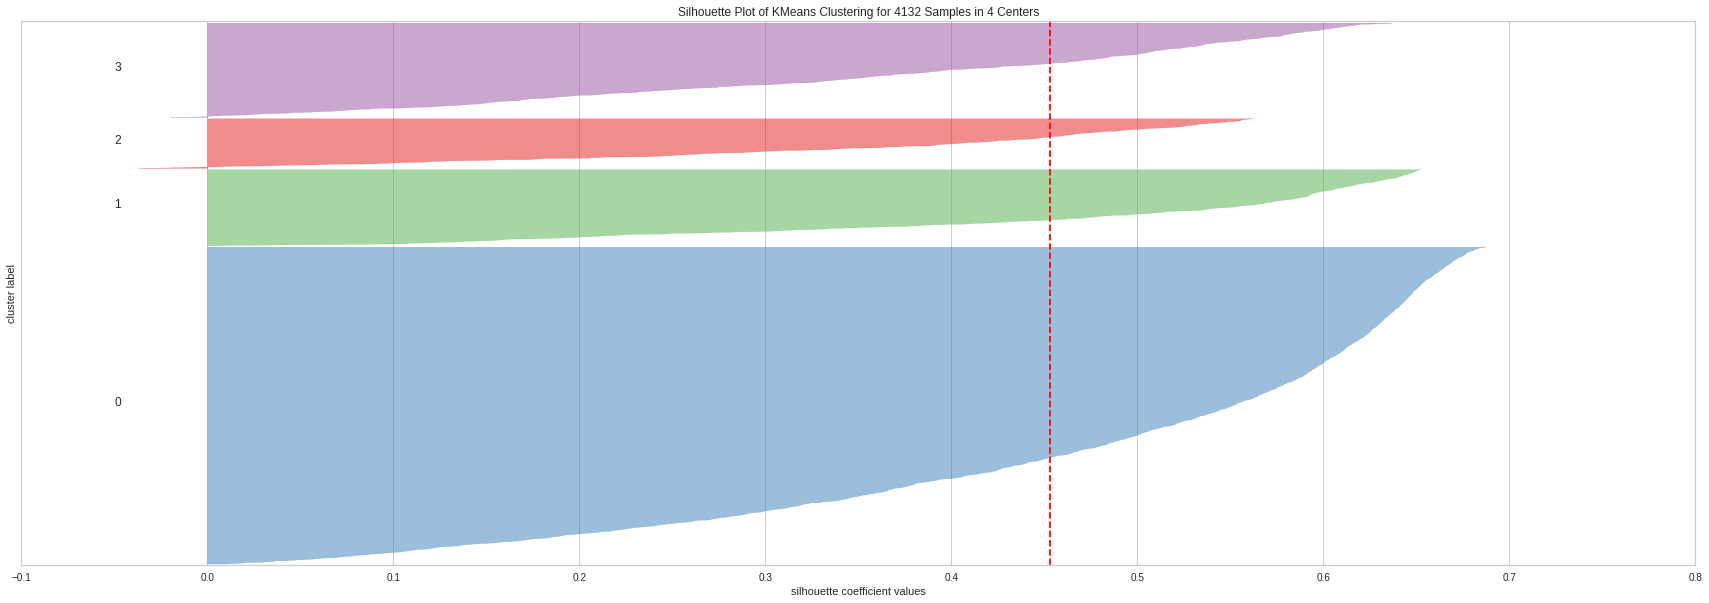

For n_clusters = 5, silhouette score is 0.4520270339969211


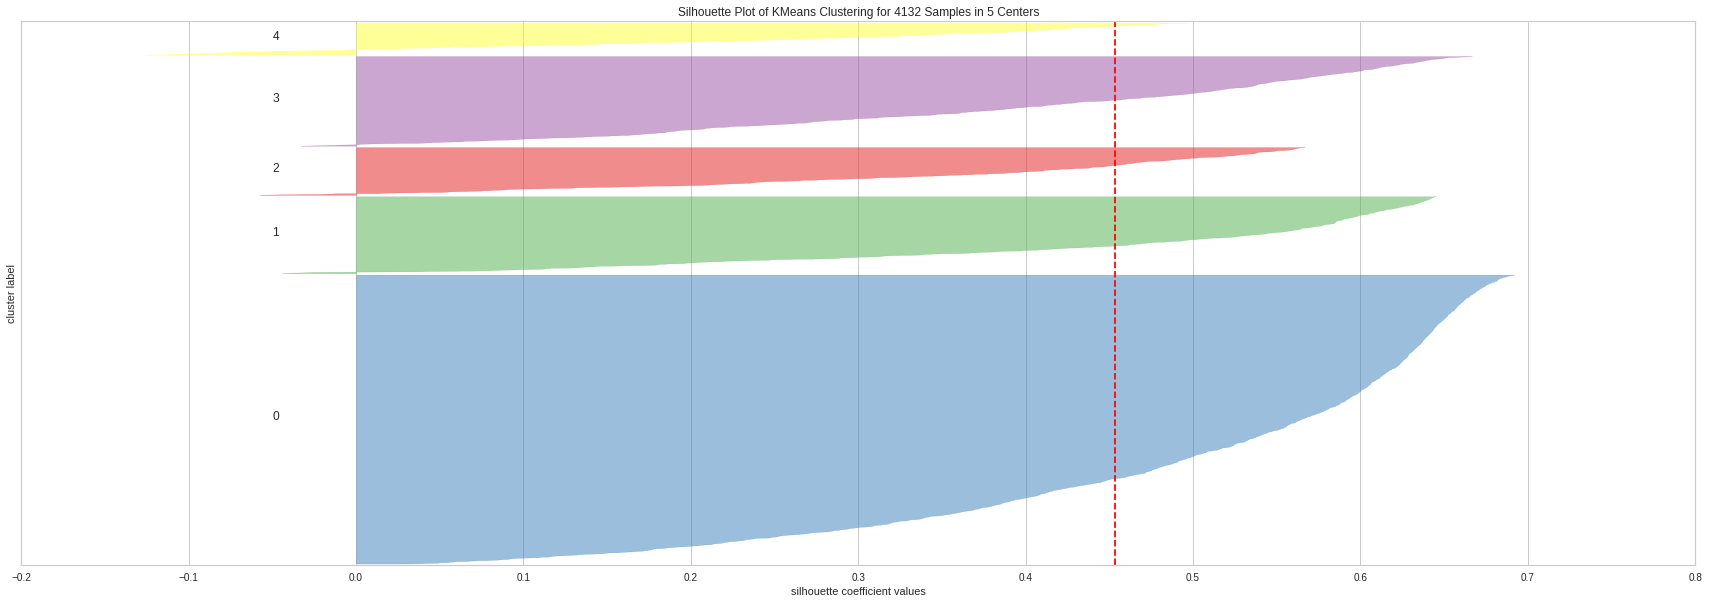

In [34]:
n=6
for n_clusters in range(2,n):
    km = KMeans (n_clusters=n_clusters, max_iter=100,tol=0.01)
    preds = km.fit_predict(X_r)
    centers = km.cluster_centers_
    score = silhouette_score(X_r, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
    visualizer = SilhouetteVisualizer(km)
    visualizer.fit(X_r) 
    visualizer.poof()                                                           #on Pca as well number of Clusters perform Best

In [35]:
km = KMeans(n_clusters=4, max_iter=100,tol=0.01)                               #finally predicting Clusters for K=4
preds = km.fit_predict(X_r)

Explained variance ratio (first two components): [0.71161027 0.14168677 0.09597341]


<Figure size 2160x720 with 0 Axes>

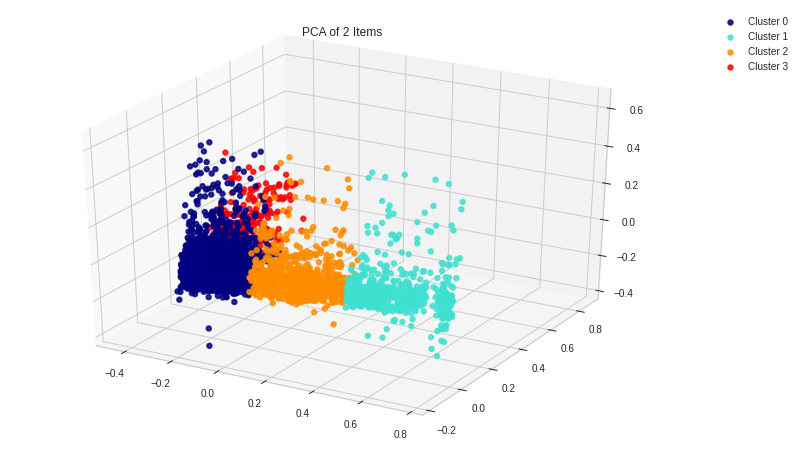

In [36]:
X_r,y_num,pca=pca_val(X,preds)
plot_3d(X_r,y_num,pca)                                                              #Explains 98% of Variance

In [37]:
final_df['Cluster']=preds                                                       #Loading the Cluster Values on Dataset
final_df.head()

,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity,Cluster
CustomerID,,,,,,,,
12346.0,1,1,1.0,325,0.000000,0.00,0.000000,1
12347.0,0,0,182.0,1,23.681319,4310.00,13.505495,3
12349.0,0,0,73.0,18,24.076027,1757.55,8.643836,0
12350.0,0,0,17.0,309,19.670588,334.40,11.588235,1
12352.0,0,10,85.0,35,16.267474,1545.41,4.947368,0


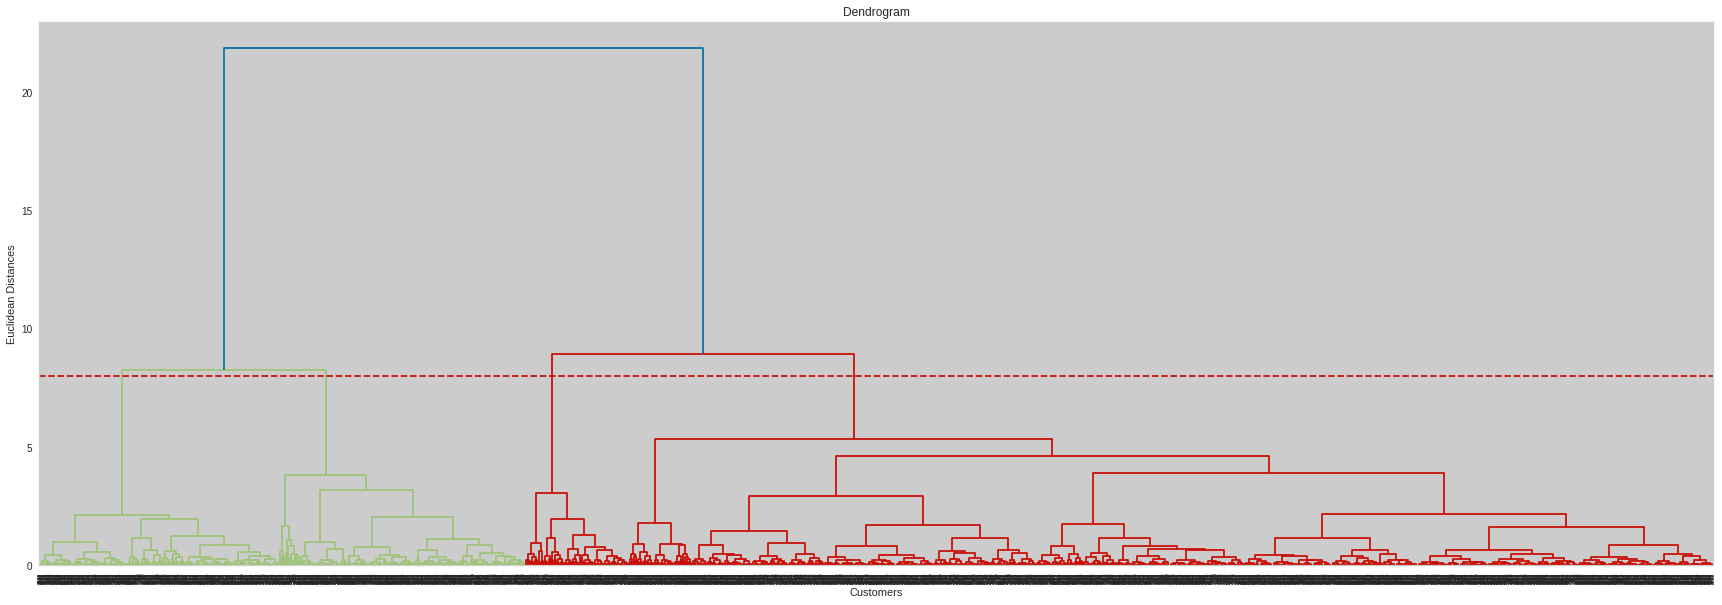

In [43]:
dendrogram = sch.dendrogram(sch.linkage(X_r, method = 'ward'))                   #Doing Hierarchical Clustering and plotting a Dendogram to Visualize the Perfect value of K
plt.axhline(y=8, color='r', linestyle='--')
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.show()                                                                      # 4 Cluster looks Good

Now, that we have 5 customer Segments ( 4 from Kmeans Clusters and 1 of wholesalers), Lets Define them

Number of Customers in Segment 1 = 2447


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity,Cluster
CustomerID,,,,,,,,
12349.0,0,0,73.0,18,24.076027,1757.55,8.643836,0
12352.0,0,10,85.0,35,16.267474,1545.41,4.947368,0
12356.0,0,0,59.0,22,47.651356,2811.43,26.966102,0
12358.0,0,0,19.0,1,61.476842,1168.06,13.052632,0
12360.0,0,0,129.0,51,20.636124,2662.06,9.031008,0


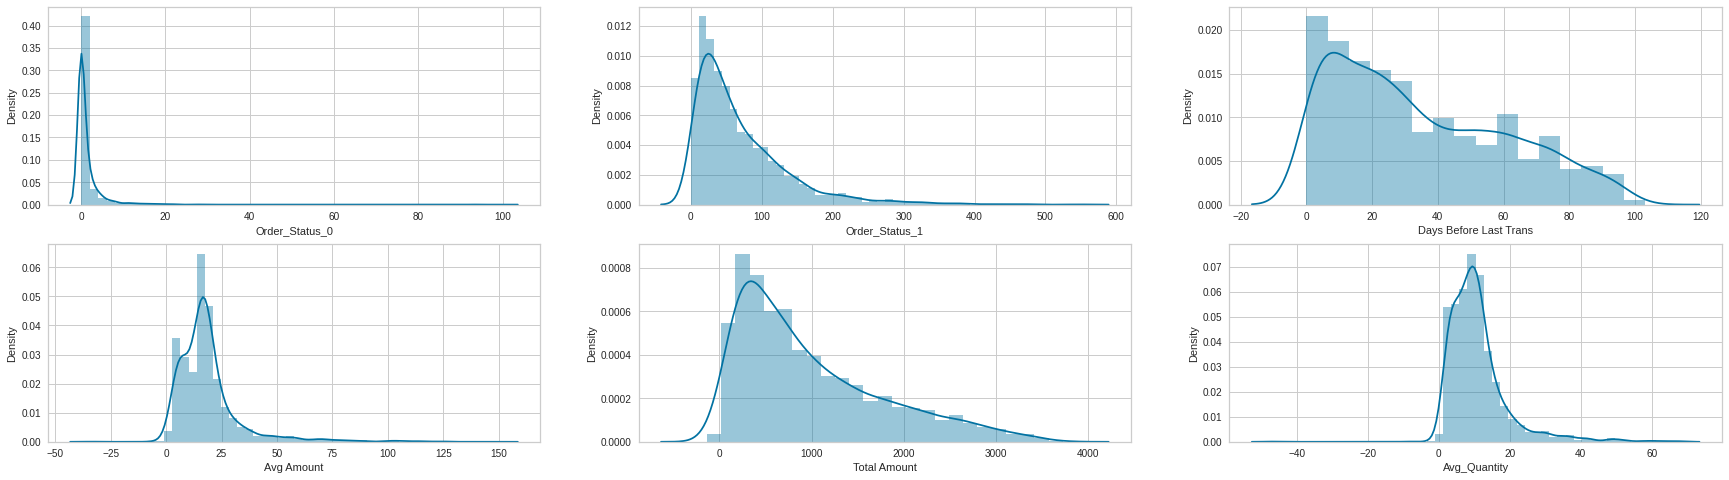

In [44]:
Cluster_0=final_df[final_df['Cluster']==0]
Cluster_1=final_df[final_df['Cluster']==1]   
Cluster_2=final_df[final_df['Cluster']==2] 
Cluster_3=final_df[final_df['Cluster']==3] 
print(f'Number of Customers in Segment 1 = {Cluster_0.shape[0]}')
plot_dist(Cluster_0,fig_size=(30,8))
Cluster_0.head()

Customer Segment 1: Active Customers with medium buying frequency and Avg Transaction Values. 

Number of Customers in Segment 2 = 581


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity,Cluster
CustomerID,,,,,,,,
12346.0,1,1,1.0,325,0.000000,0.00,0.000000,1
12350.0,0,0,17.0,309,19.670588,334.40,11.588235,1
12354.0,0,0,58.0,231,18.610345,1079.40,9.137931,1
12361.0,0,0,10.0,286,18.990000,189.90,9.100000,1
12365.0,0,1,22.0,290,13.943043,320.69,7.521739,1


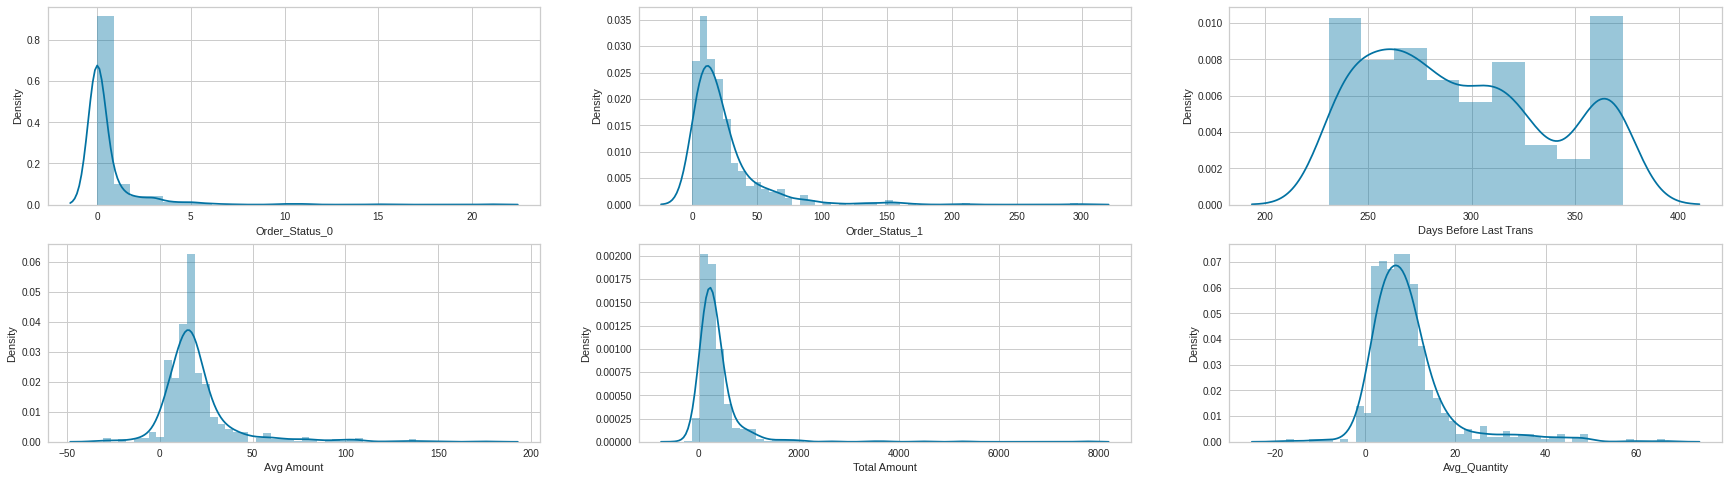

In [45]:
print(f'Number of Customers in Segment 2 = {Cluster_1.shape[0]}')
plot_dist(Cluster_1,fig_size=(30,8))
Cluster_1.head()

Customer Segment 2: Passive Customers with low buying Frequency and medium transaction Values

Number of Customers in Segment 3 = 719


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity,Cluster
CustomerID,,,,,,,,
12353.0,0,0,4.0,203,22.250000,89.00,5.000000,2
12355.0,0,0,13.0,213,35.338462,459.40,18.461538,2
12363.0,0,0,23.0,109,24.000000,552.00,17.739130,2
12378.0,0,0,219.0,129,18.304201,4008.62,11.547945,2
12383.0,0,1,99.0,184,18.393100,1839.31,15.290000,2


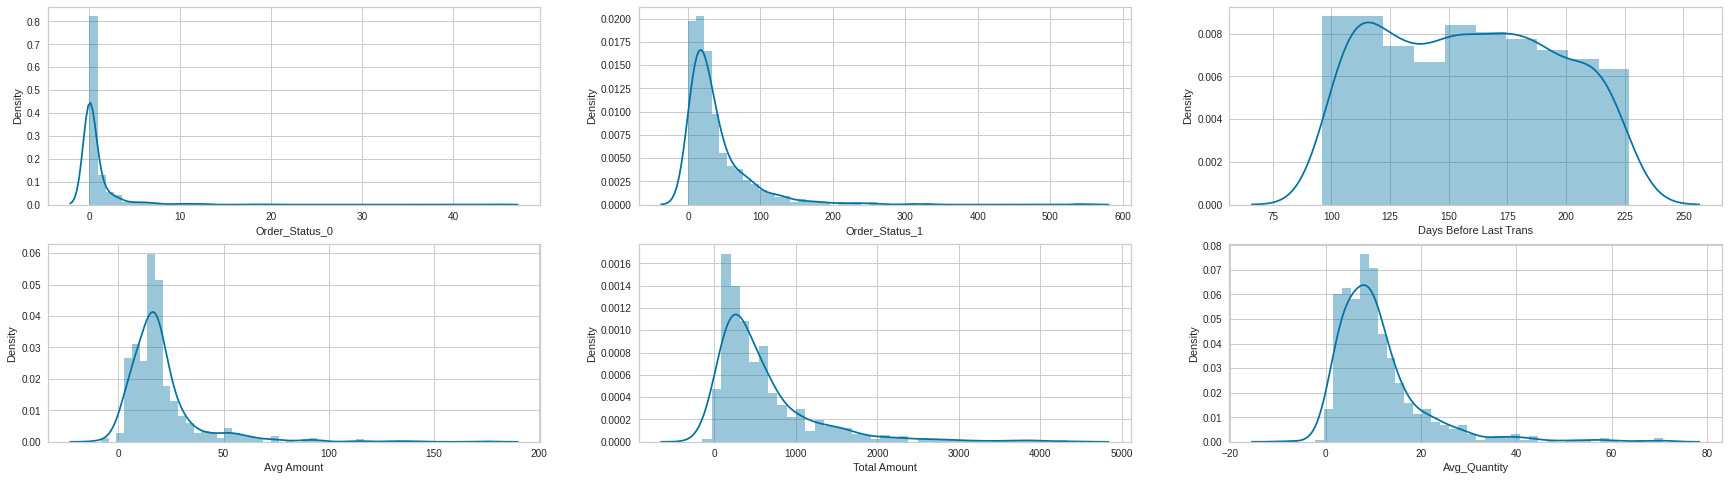

In [46]:
print(f'Number of Customers in Segment 3 = {Cluster_2.shape[0]}')
plot_dist(Cluster_2,fig_size=(30,8))
Cluster_2.head()

Customer Segment 3: Passive Customers with low buying Frequency and transaction Values

Number of Customers in Segment 4 = 385


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity,Cluster
CustomerID,,,,,,,,
12347.0,0,0,182.0,1,23.681319,4310.00,13.505495,3
12357.0,0,0,131.0,32,47.386794,6207.67,20.671756,3
12359.0,0,6,248.0,7,24.588701,6245.53,6.346457,3
12362.0,0,8,266.0,2,18.812336,5154.58,8.072993,3
12370.0,0,0,167.0,50,21.231677,3545.69,14.089820,3


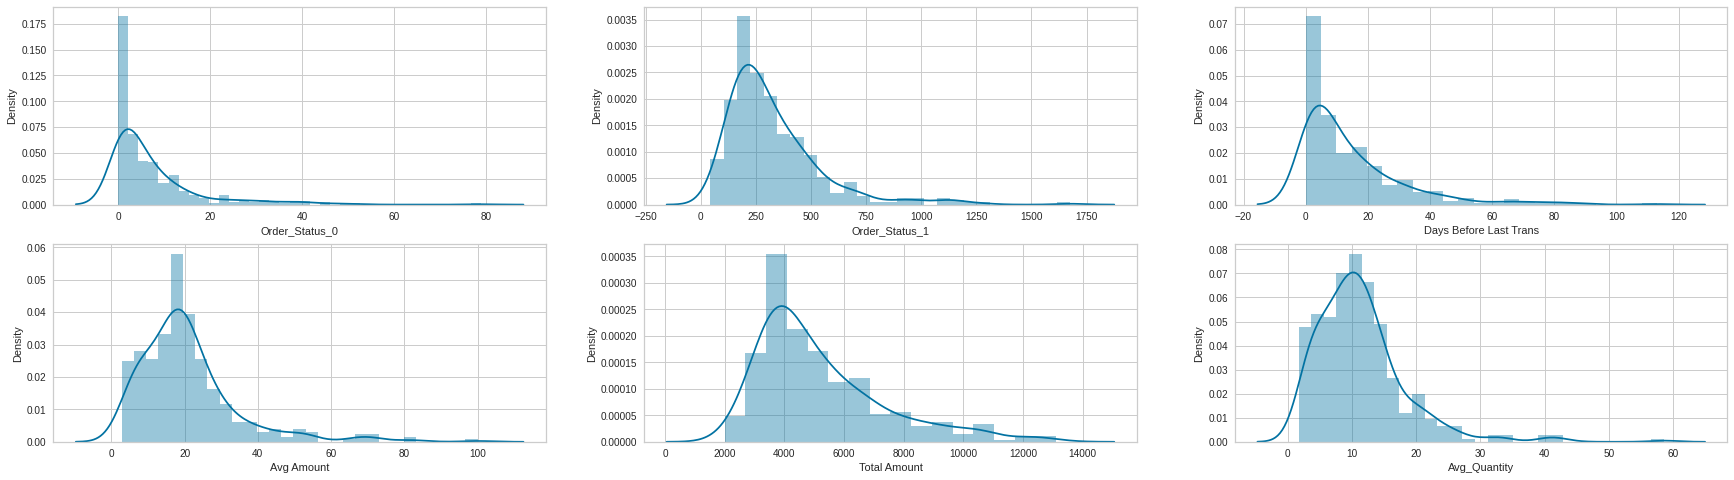

In [47]:
print(f'Number of Customers in Segment 4 = {Cluster_3.shape[0]}')
plot_dist(Cluster_3,fig_size=(30,8))
Cluster_3.head()

Customer Segment 4: Active Customers with high Order frequency and Tansaction Value

Number of Customers in Segment 5 = 22


,Country,Order_Status_0,Order_Status_1,Days Before Last Trans,Avg Amount,Total Amount,Avg_Quantity
CustomerID,,,,,,,
12798.0,0,0,8.0,9,872.130000,6977.04,657.000000
12875.0,1,0,2.0,142,171.615000,343.23,1009.500000
13027.0,1,0,26.0,113,265.846154,6912.00,664.615385
13135.0,1,0,1.0,196,3096.000000,3096.00,4300.000000
13256.0,1,0,1.0,13,0.000000,0.00,12540.000000


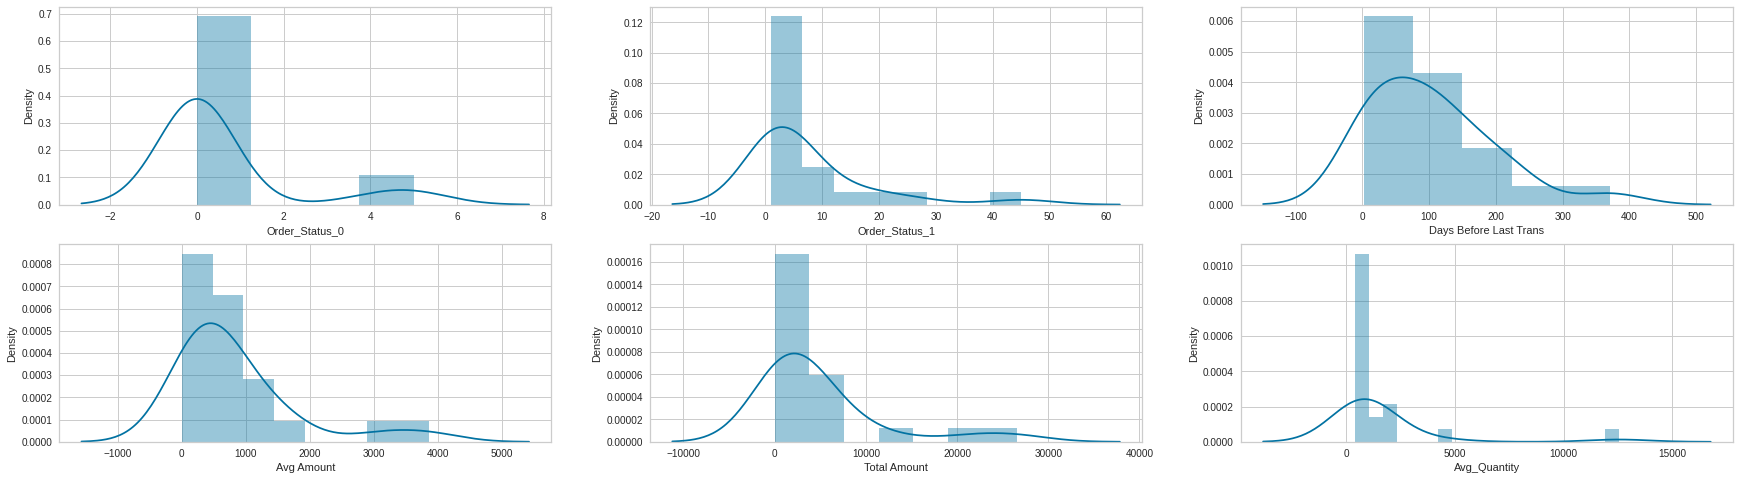

In [48]:
print(f'Number of Customers in Segment 5 = {df_wholesalers.shape[0]}')
plot_dist(df_wholesalers,fig_size=(30,8))
df_wholesalers.head()

Customer Segment 5(wholesalers): Active Customers with low order frequency, high Total Amounts and Really high Quantities Order

We are done!! Customers are Segmented in 5 Different Groups, based on their behaviours, hope company would Target each customer accordingly now and the buisness would grow.